To get started, 

This notebook is based on code found at: 

https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html


In [ ]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

Import image that we want to classify. Based on code from SML course UU - lab exercise

RGB image of size (640, 427)


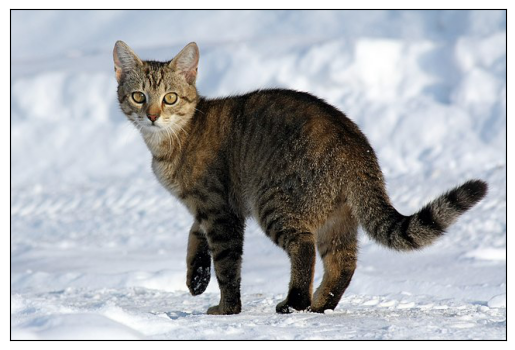

In [ ]:
from urllib.request import urlopen
from urllib.error import URLError
import matplotlib.pyplot as plt

image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/640px-Felis_catus-cat_on_snow.jpg'


try:
    with Image.open(urlopen(image_url)) as im:
        # The following fixes some problems when loading images:
        # https://stackoverflow.com/a/64598016
        image = im.convert("RGB")
except (URLError, OSError):
    print("please provide a valid URL or local path")
else:    
    print(f"{image.mode} image of size {image.size}")
    plt.imshow(np.asarray(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()

Preprocess image

In [ ]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [ ]:
tensor = preprocess(image)

In [ ]:
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)

Load pre-trained model

In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.eval()

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [ ]:
final_layer = model._modules.get('layer4')

In [ ]:
activated_features = SaveFeatures(final_layer)

In [ ]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

<ipython-input-43-5893ac2c4294>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


In [ ]:
topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.3647]),
indices=tensor([287]))

 https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
 
 287: 'lynx, catamount',

In [ ]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [ ]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [ ]:
weight_softmax_params

In [ ]:
class_idx = topk(pred_probabilities,1)[1].int()
class_idx

tensor([287], dtype=torch.int32)

In [ ]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )


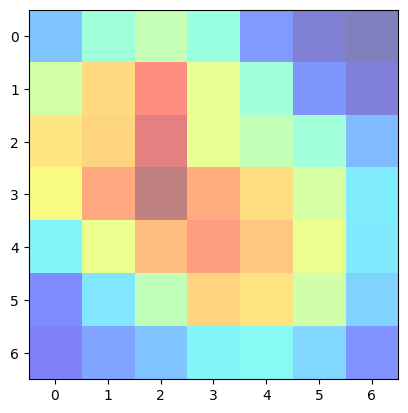

In [ ]:
imshow(overlay[0], alpha=0.5, cmap='jet')

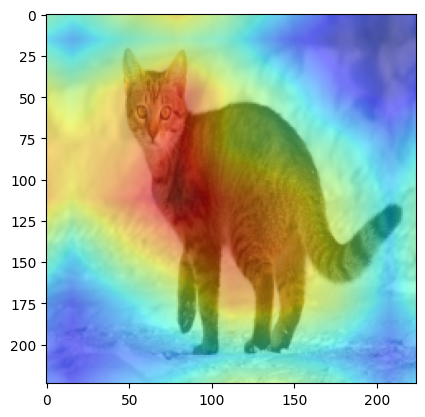

In [ ]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

In [ ]:
class_idx = topk(pred_probabilities,2)[1].int()

In [ ]:
class_idx

tensor([287, 282], dtype=torch.int32)

Picking the second best prediction

In [ ]:
overlay = getCAM(activated_features.features, weight_softmax, 282 )

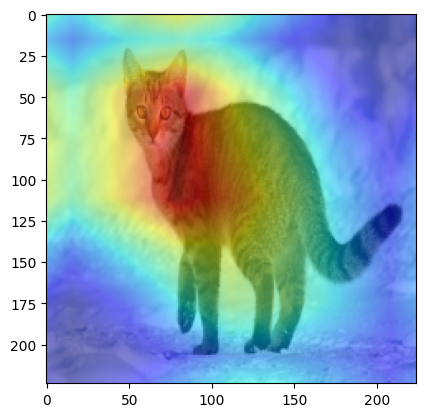

In [ ]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');


Lets check the heat map for some other classes 



*   527: 'desktop computer'
*   587: 'hammer'





In [ ]:
overlay = getCAM(activated_features.features, weight_softmax, 587 ) 

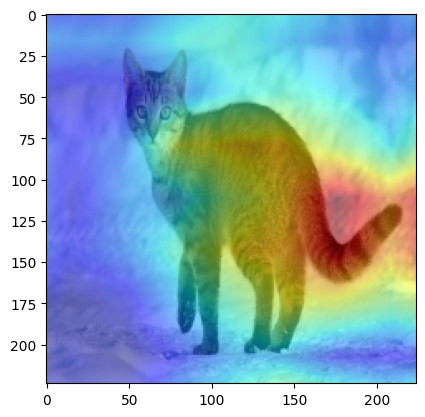

In [ ]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');